In [54]:
import pandas as pd

from matplotlib import pyplot as plt

from tqdm import tqdm

In [40]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import classification_report, f1_score, recall_score, precision_score

In [9]:
from imblearn.over_sampling import SMOTE

In [10]:
data = pd.read_csv('project_data.csv')
data.head(10)

,ELMO2,CREB3L1,RPS11,PNMA1,MMP2,C10orf90,ZHX3,ERCC5,GPR98,RXFP3,...,GRIP2,GPLD1,RAB8A,RXFP2,PIK3IP1,SLC39A6,SNRPD2,AQP7,CTSC,label
0,0.543250,0.22150,-0.260750,-0.37725,0.494500,-2.332500,0.099500,-0.41600,0.432375,0.2495,...,0.01750,1.398833,0.0598,0.8555,1.19075,2.9684,-0.5929,-0.5935,0.1657,1
1,1.126250,0.65250,0.119500,0.86675,1.315667,-2.431000,-0.296667,-0.22125,-0.350500,0.1260,...,0.05850,-0.259667,1.3683,0.2785,2.57425,2.4282,0.4476,-0.6615,0.9524,1
2,-0.097833,0.87075,0.045500,-1.22150,-0.544833,-2.118250,0.428167,-0.13900,-0.145625,-0.1520,...,-0.97025,-1.761167,-0.2321,-0.2020,2.07175,0.2635,0.7134,-0.8645,-0.1184,1
3,0.449583,0.16475,-0.550875,0.51075,0.348667,-0.807250,-1.072833,-0.56850,-1.437250,0.4845,...,0.01750,-0.450667,1.7279,0.0910,2.13950,-1.8028,-0.0696,0.0570,0.6881,1
4,0.413667,1.35900,0.601750,1.26500,0.028000,-2.391500,0.008333,-0.13325,-1.876000,0.4510,...,-1.29100,-1.214833,0.1056,0.3545,1.66675,2.8042,-0.1138,-1.6980,-0.6568,1
5,0.436333,-0.04350,0.208125,0.23975,-1.130167,-2.204750,1.177167,0.40650,0.256500,0.5150,...,-0.29200,0.089500,0.1273,0.3170,2.26575,3.0265,-0.2115,-0.9400,-0.0443,1
6,-0.123083,1.14400,0.298375,-0.53550,2.458667,-0.393000,-0.745500,-0.01675,-1.725625,-0.0500,...,-0.02300,-0.580333,-0.0044,0.4560,2.24550,-1.6863,-0.5876,0.1140,-0.5477,1
7,-0.037083,1.40025,1.406625,-0.42125,-0.217167,-1.404500,-0.569167,0.91700,1.048000,-0.0150,...,-0.30950,-0.307000,0.2461,2.2565,3.44400,1.9315,0.3168,1.6780,0.6586,1
8,-0.270818,2.66750,2.191125,-0.99675,3.825667,1.371667,-0.860333,-1.40375,0.208250,3.9070,...,1.20100,1.516667,-0.0346,0.1890,1.78125,-2.2335,1.8620,1.4320,1.6107,0
9,0.563750,1.28450,-0.222500,0.10800,1.158833,-2.398250,-0.345167,-0.76775,0.288750,0.4935,...,-0.02775,-1.778500,0.3082,-0.0515,2.29250,-2.6111,0.3225,-0.9425,0.4393,1


In [11]:
data.shape

(590, 17815)

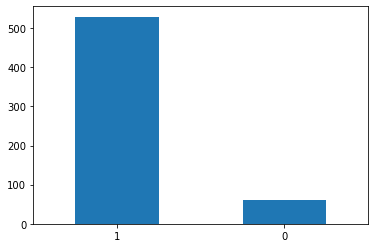

In [12]:
data.label.value_counts().plot.bar()
plt.xticks(rotation=0);

In [13]:
data.label.value_counts()

1    529
0     61
Name: label, dtype: int64

In [14]:
data.fillna(data.mean(), inplace=True)
data.isna().sum().sum()

0

In [16]:
X_train, X_test, y_train, y_test = train_test_split(data.iloc[:, :-1], data.iloc[:, -1], test_size=0.33, stratify=data.label)

In [24]:
sm = SMOTE(sampling_strategy='auto', random_state=2022)
X_resampled, y_resampled = sm.fit_resample(X_train,list(y_train))

In [63]:
model_rf = RandomForestClassifier()
model_mlp = MLPClassifier()
model_log = LogisticRegression()
eclf1 = VotingClassifier(estimators=[('rf', model_rf), ('mlp', model_mlp), ('log', model_log)], voting='soft')

In [68]:
def test(X, y, model, smote=True):
    kf = StratifiedKFold(n_splits = 3, shuffle = True, random_state = 50)
    recall_history = []
    precision_history = []
    f1_history = []
    for train_index, test_index in tqdm(kf.split(X, y)):
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]
        if smote:
            sm = SMOTE(sampling_strategy='auto', random_state=2022)
            X_train, y_train = sm.fit_resample(X_train,list(y_train))

        model.fit(X_train, y_train) # 모델 학습

        y_pred = model.predict(X_test) # 예측 라벨
        recall_history.append((recall_score(y_pred, y_test), recall_score(y_pred, y_test, pos_label=0)))
        precision_history.append((precision_score(y_pred, y_test), precision_score(y_pred, y_test, pos_label=0)))
        f1_history.append((f1_score(y_pred, y_test), f1_score(y_pred, y_test, pos_label=0)))
        
    return  precision_history, recall_history, f1_history

In [59]:
data = pd.read_csv('project_data.csv')
data.fillna(data.mean(), inplace=True)
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

In [69]:
test(X, y, eclf1)

1it [00:42, 42.56s/it]C:\Users\bhkim\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
3it [02:20, 46.86s/it]


([(0.9943502824858758, 0.95), (1.0, 1.0), (1.0, 1.0)],
 [(0.9943502824858758, 0.95), (1.0, 1.0), (1.0, 1.0)],
 [(0.9943502824858758, 0.9500000000000001), (1.0, 1.0), (1.0, 1.0)])

In [70]:
test(X, y, eclf1, False)

3it [00:53, 17.74s/it]


([(0.9943502824858758, 0.9), (1.0, 1.0), (1.0, 1.0)],
 [(0.9887640449438202, 0.9473684210526315), (1.0, 1.0), (1.0, 1.0)],
 [(0.9915492957746479, 0.9230769230769231), (1.0, 1.0), (1.0, 1.0)])